In [0]:
# Essential Libraries
import numpy as np
import matplotlib.pyplot as plt
# from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import tensorflow as tf


In [3]:
# Loading the Data
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# Reshaping the Data
# Extending Dimension for Conv layer
X_train = X_train.reshape(-1, 28, 28, 1) 
# Changing datatype to float32
X_train = X_train.astype('float32')
X_train /= 255

X_test = X_test.reshape(X_test.shape[0], -1)
X_test = X_test.reshape(-1, 28, 28, 1) #check
X_test = X_test.astype('float32')
X_test /= 255

# Adding Gaussian Noise for Denosing Autoencoder

noise_factor = 0.4
X_train_noisy = X_train + noise_factor * np.random.normal(size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(size=X_test.shape)

X_train_noisy = np.clip(X_train_noisy, 0.0, 1.0)
X_test_noisy = np.clip(X_test_noisy, 0.0, 1.0)



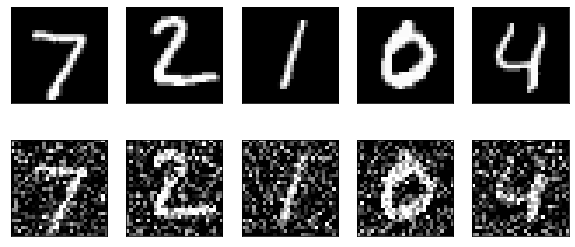

In [5]:
n = 5
plt.figure(figsize=(10, 4.5))
for i in range(n):
    # plot original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')

In [0]:
# encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
# encoded_layer1 = BatchNormalization()(encoded_layer1)
# encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
# encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
# encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
# encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
# latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

# decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
# decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
# decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
# decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
# decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
# decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
# output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

In [6]:
# Denosing Autoencoder Architecture

# Input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer) #28 x 28 x 32
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
conv3 = BatchNormalization()(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
conv4 = BatchNormalization()(conv4)


# # decoding architecture
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
conv5 = BatchNormalization()(conv5)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
conv6 = BatchNormalization()(conv6)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
conv6 = BatchNormalization()(conv6)
up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
conv7 = BatchNormalization()(conv7)
up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1


# compile the model
model1 = Model(input_layer, decoded)
model1.compile(optimizer='adam', loss='mse')
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1849

In [8]:
# training the data to Denoising Autoencoder
autoencoder_train=model1.fit(X_train_noisy, X_train, epochs=20,batch_size = 128)

Epoch 1/20
60000/60000 [==============================] - 42s 706us/step - loss: 0.0201
Epoch 2/20
60000/60000 [==============================] - 33s 556us/step - loss: 0.0102
Epoch 3/20
60000/60000 [==============================] - 33s 556us/step - loss: 0.0087
Epoch 4/20
60000/60000 [==============================] - 33s 555us/step - loss: 0.0077
Epoch 5/20
60000/60000 [==============================] - 34s 563us/step - loss: 0.0073
Epoch 6/20
60000/60000 [==============================] - 34s 563us/step - loss: 0.0071
Epoch 7/20
60000/60000 [==============================] - 34s 564us/step - loss: 0.0069
Epoch 8/20
60000/60000 [==============================] - 34s 565us/step - loss: 0.0068
Epoch 9/20
60000/60000 [==============================] - 34s 563us/step - loss: 0.0067
Epoch 10/20
60000/60000 [==============================] - 34s 563us/step - loss: 0.0065
Epoch 11/20
60000/60000 [==============================] - 34s 562us/step - loss: 0.0064
Epoch 12/20
60000/60000 [=====

In [0]:
# loss = autoencoder_train.history['loss']
# # val_loss = autoencoder_train.history['val_loss']
# epochs = range(40)
# plt.figure()
# plt.plot(epochs, loss, label='Training loss')
# # plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training loss')
# plt.legend()
# plt.show()

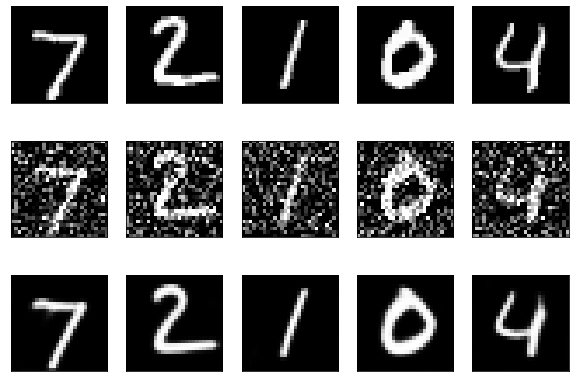

In [13]:
# Comparision original image vs Noisy Image vs Denoising Autoencode output
n = 5
plt.figure(figsize=(10, 7))

images = model1.predict(X_test_noisy)

for i in range(n):
    # plot original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')
        
    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Autoencoder Output')

In [14]:


from keras.layers import Flatten
from keras.layers import Dropout

from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

# Connecting Pretrained layer to new model for task3
num_classes = 10
for i in range(33):
    model1.layers[i].trainable = True

ll = model1.layers[33].output 

flatten = Flatten()(ll)

dense1 = Dense(64, activation='relu')(flatten)
dense2=Dense(64, activation='relu')(dense1)
output = Dense(10, activation='softmax')(dense2)
model3 = Model(inputs=model1.input,outputs=output)
model3.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1849

In [15]:
# Loading Fashion MNIST Dataset
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
# Reshaping Fashion MNIST
import pandas as pd
X_train = X_train.reshape(-1, 28, 28, 1)  #for the conv layer approac
X_train = X_train.astype('float32')
X_train /= 255

X_test = X_test.reshape(-1, 28, 28, 1) #check
X_test = X_test.astype('float32')
X_test /= 255



In [0]:
# Categorical binary classification of test Data
from keras.utils import np_utils
num_classes = 10
y_train_ohe = np_utils.to_categorical(Y_train, num_classes)
y_test_ohe = np_utils.to_categorical(Y_test, num_classes)

In [0]:
import keras
model3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
from keras.callbacks import ModelCheckpoint
model_fname='model3'
callbacks = [ModelCheckpoint(monitor='val_acc', filepath=model_fname + '.hdf5',
                             save_best_only=True, save_weights_only=True,
                             mode='min')]

In [20]:
batch_size = 128
num_classes = 10
epochs = 20
history = model3.fit(X_train, y_train_ohe,
          epochs=epochs,
          batch_size = batch_size,
          validation_data=(X_test, y_test_ohe),
          verbose=1,
         )

# score = new_model.evaluate(X_test, y_test, verbose=0)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 39s 647us/step - loss: 0.4382 - accuracy: 0.8408 - val_loss: 0.3103 - val_accuracy: 0.8858
Epoch 2/20
60000/60000 [==============================] - 36s 600us/step - loss: 0.2579 - accuracy: 0.9052 - val_loss: 0.2886 - val_accuracy: 0.8955
Epoch 3/20
60000/60000 [==============================] - 36s 602us/step - loss: 0.2147 - accuracy: 0.9215 - val_loss: 0.2521 - val_accuracy: 0.9108
Epoch 4/20
60000/60000 [==============================] - 36s 601us/step - loss: 0.1847 - accuracy: 0.9315 - val_loss: 0.2318 - val_accuracy: 0.9164
Epoch 5/20
60000/60000 [==============================] - 36s 600us/step - loss: 0.1611 - accuracy: 0.9405 - val_loss: 0.2521 - val_accuracy: 0.9133
Epoch 6/20
60000/60000 [==============================] - 36s 600us/step - loss: 0.1441 - accuracy: 0.9474 - val_loss: 0.2371 - val_accuracy: 0.9193
Epoch 7/20
60000/60000 [==============================] 

In [22]:
predictions = new_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes.shape


(10000,)

In [23]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(Y_test, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.01      0.03      0.02      1000
     Class 1       0.00      0.01      0.00      1000
     Class 2       0.04      0.02      0.02      1000
     Class 3       0.00      0.00      0.00      1000
     Class 4       0.51      0.20      0.28      1000
     Class 5       0.20      0.05      0.08      1000
     Class 6       0.04      0.01      0.02      1000
     Class 7       0.00      0.00      0.00      1000
     Class 8       0.09      0.44      0.14      1000
     Class 9       0.03      0.01      0.01      1000

    accuracy                           0.08     10000
   macro avg       0.09      0.08      0.06     10000
weighted avg       0.09      0.08      0.06     10000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


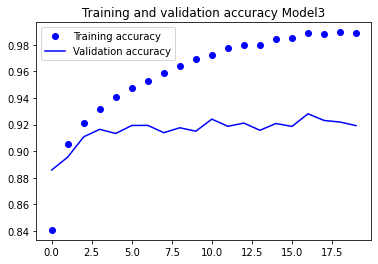

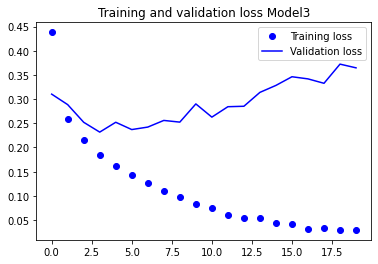

In [24]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy Model3')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss Model3')
plt.legend()
plt.show()

(10000,)

In [0]:
correct_indices = np.nonzero(predicted_classes == Y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != Y_test)[0]

              precision    recall  f1-score   support

     Class 0       0.87      0.87      0.87      1000
     Class 1       0.99      0.98      0.99      1000
     Class 2       0.92      0.85      0.89      1000
     Class 3       0.93      0.92      0.92      1000
     Class 4       0.85      0.93      0.89      1000
     Class 5       0.98      0.99      0.99      1000
     Class 6       0.77      0.78      0.78      1000
     Class 7       0.97      0.97      0.97      1000
     Class 8       0.99      0.98      0.99      1000
     Class 9       0.98      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



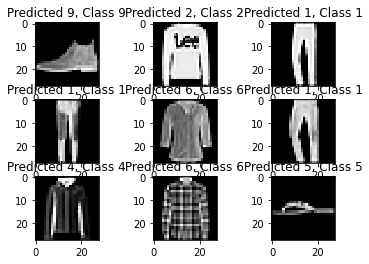

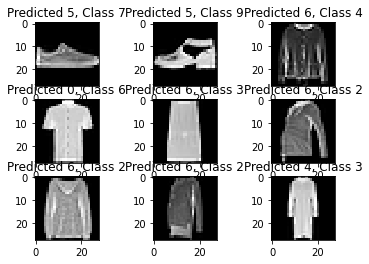

In [0]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], Y_test[correct]))
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], Y_test[incorrect]))



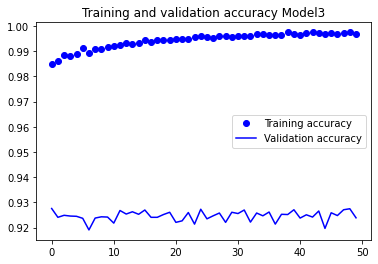

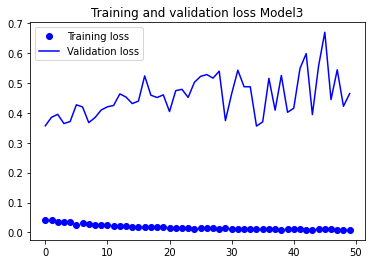